# Convergence plot. Minimal BMN

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../figures/paper.mplstyle")

## Read data from disk

* If the data is in `HDF5` format save in a `.h5` file, use the following code

In [253]:
# parameters
def read_data(
    optimizer: str,
    p: dict,
):
    """Read the VQE convergence data for the mini BMN model from disk

    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
    Returns:
        pandas.DataFrame: The dataframe collecting the results of the convergence
    """
    filename = f"{p['f']}_l{p['l']}_convergence_{optimizer}_{p['v']}_depth{p['d']}_reps{p['n']}_max{p['m']}.h5"
    try:
        df = pd.read_hdf(filename, "vqe")
    except FileNotFoundError as e:
        print(f"{filename} not found. {e}")
        sys.exit()
    return df[df.counts<=p["s"]*p['m']]  # only keep counts less than maxit

* If the data is in `pickle` format saved and compressed in a `.gz` file.,use the following code

In [252]:
# parameters
def read_data_pickle(
    optimizer: str,
    p: dict,
):
    """Read the VQE convergence data for the mini BMN model from disk

    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
    Returns:
        pandas.DataFrame: The dataframe collecting the results of the convergence
    """
    filename = f"{p['f']}_l{p['l']}_convergence_{optimizer}_{p['v']}_depth{p['d']}_reps{p['n']}_max{p['m']}.gz"
    try:
        df = pd.read_pickle(filename)
    except FileNotFoundError as e:
        print(f"{filename} not found. {e}")
        sys.exit()
    return df[df.counts<=p["s"]*p['m']]  # only keep counts less than maxit

In [224]:
def collect_data(
    optimizers: list,
    p: dict,
    h5: bool = True,
):
    """Read the VQE convergence data for the mini BMN model from disk
    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
        h5 (bool, optional): if the file to collect data from are in HDF5 format. Defaults to true
    Returns:
        pandas.DataFrame: The dataframe collecting the all the results of the convergence
    """
    # concatenate the results from all files
    if h5:
        frames = [read_data(o, p) for o in optimizers]
    else:
        frames = [read_data_pickle(o, p) for o in optimizers]
    return pd.concat(frames, keys=optimizers, names=["Optimizer"])


Parameters

In [290]:
depth = 9
g2N = 0.5
varform = ['ry','rz']
nrep = 100
maxit = 10000
datafolder = "../data/miniBMN_L2"

In [291]:
params = dict()
params["l"] = str(g2N).replace(".", "")
params["d"] = depth
params["v"] = "-".join(varform)
params["m"] = maxit
params["n"] = nrep
params["f"] = datafolder
params["s"] = 1.0  # factor to scale up maxit (works for SLSQP which does not care about maxit)

In [260]:
df = read_data_pickle("COBYLA",params)

<AxesSubplot:xlabel='counts', ylabel='energy'>

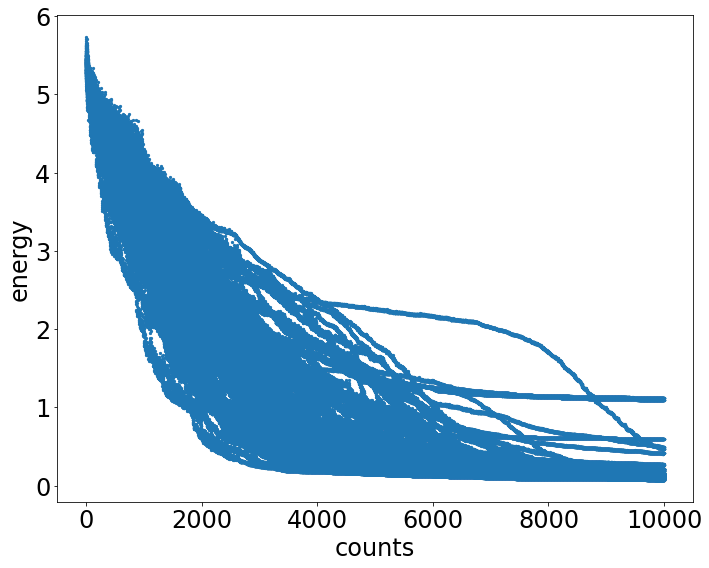

In [261]:
df.plot.scatter(x='counts',y='energy',marker='.')

Collect multiple data in one frame

In [292]:
# opt_label = ["COBYLA", "L-BFGS-B","SLSQP"]#,"NELDER-MEAD"]
opt_label = ["COBYLA", "L-BFGS-B","SLSQP","NELDER-MEAD"]
# opt_label = ["COBYLA"]
result = collect_data(opt_label,params,h5=False)

In [149]:
result

counts    energy casimir
Optimizer   rep                          
COBYLA      0         1  6.198801     NaN
            0         2  5.398171     NaN
            0         3  5.510142     NaN
            0         4  5.540324     NaN
            0         5  5.355117     NaN
...                 ...       ...     ...
NELDER-MEAD 99     9997  0.138547     NaN
            99     9998  0.138366     NaN
            99     9999  0.138855     NaN
            99    10000  0.138949     NaN
            99    10001  0.138537     NaN

[2609598 rows x 3 columns]

In [185]:
result.groupby('rep').apply(lambda x: x.sort_values(by='counts',ascending=False).iloc[:4][['counts','energy']])

counts    energy
rep Optimizer   rep                  
0   L-BFGS-B    0     10001  0.124529
    NELDER-MEAD 0     10000  0.310708
    L-BFGS-B    0     10000  0.124529
    COBYLA      0     10000  0.125317
1   L-BFGS-B    1     10001  0.124528
...                     ...       ...
98  COBYLA      98     9999  0.125557
99  NELDER-MEAD 99    10001  0.138537
    COBYLA      99    10000  0.118048
    NELDER-MEAD 99    10000  0.138949
    COBYLA      99     9999  0.118058

[400 rows x 2 columns]

## Get stats

In [259]:
result.groupby('Optimizer').apply(min).style.format(precision=5).hide_columns(['counts','casimir']) # change the precision of the output

,energy
Optimizer,
COBYLA,0.07506
L-BFGS-B,0.05597
SLSQP,0.00639


In [178]:
result.sort_values(by='energy').iloc[0]

counts         9991
energy     0.077833
casimir         NaN
Name: (COBYLA, 41), dtype: object

In [293]:
gs = dict()
for r in opt_label:
    gs[r] = result.loc[r].groupby('rep').apply(min).energy
gsdf = pd.DataFrame.from_dict(gs, dtype=float)
gsdf

,COBYLA,L-BFGS-B,SLSQP,NELDER-MEAD
rep,,,,
0,0.315922,0.252552,0.198527,3.239732
1,0.167773,0.244926,0.244551,3.617121
2,0.201783,0.246146,0.244750,3.603995
3,0.253700,0.254836,0.193511,3.302832
4,0.219823,0.242456,0.193598,3.592744
...,...,...,...,...
95,0.278124,0.254472,0.279293,3.783695
96,0.321114,0.313069,0.310790,3.582931
97,0.293029,0.186162,0.141702,3.703962


In [294]:
gsdf.describe().T[["min","max","mean","std"]].style.format(precision=5) # change the precision of the output

,min,max,mean,std
COBYLA,0.16777,1.59195,0.32429,0.18728
L-BFGS-B,0.03764,1.22114,0.26184,0.13038
SLSQP,0.03572,1.21822,0.23338,0.11667
NELDER-MEAD,2.89353,4.26227,3.69841,0.25552


In [139]:
gsdf['SLSQP'].idxmin()

39

<AxesSubplot:ylabel='Frequency'>

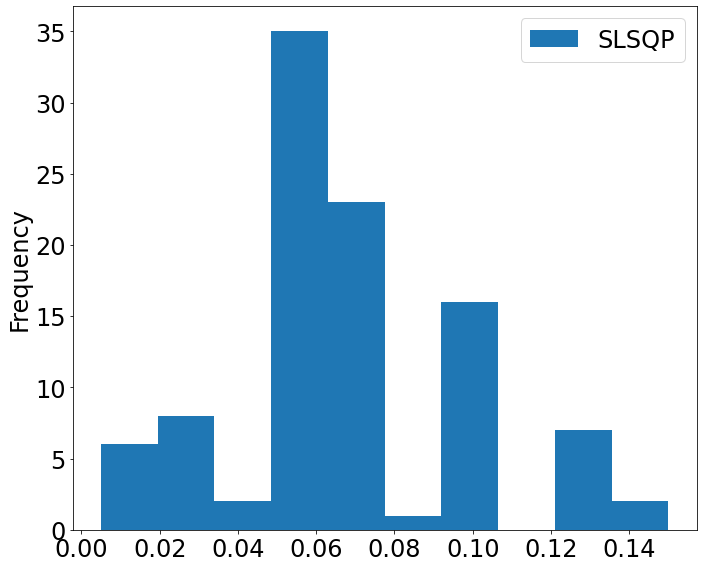

In [273]:
gsdf.sort_values(by=['SLSQP'],ascending=True).plot.hist(y='SLSQP')

<AxesSubplot:xlabel='counts'>

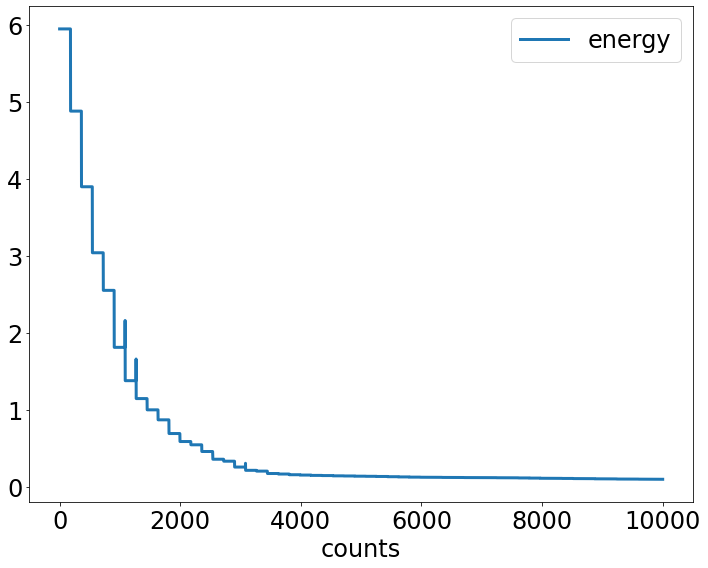

In [232]:
result.loc['SLSQP',39].plot(x='counts',y='energy')

## Plot convergence

In [288]:
ht = 0.003287

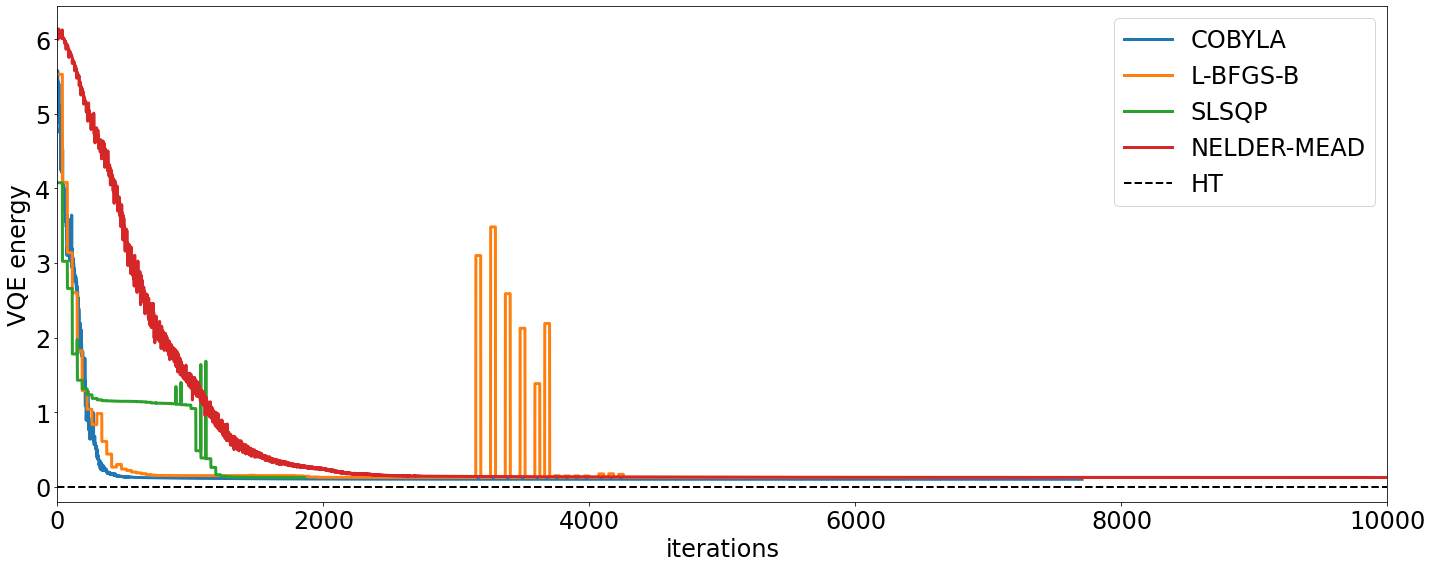

In [289]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")
ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
filename = f"../figures/miniBMN_L2_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}"
plt.savefig(f"{filename}.pdf")
plt.savefig(f"{filename}.png")
plt.savefig(f"{filename}.svg")


Zoom in

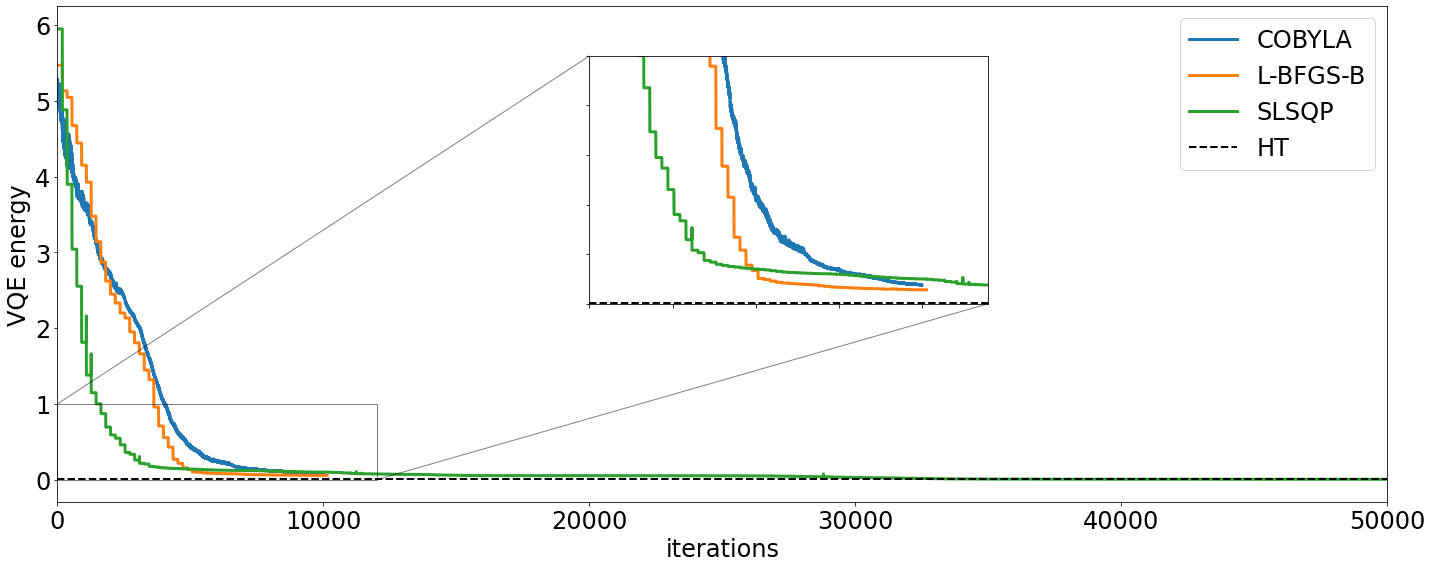

In [276]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,50000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")

# inset axes.... bounds are [x0, y0, width, height] for where to put it
axins = ax.inset_axes([0.4, 0.4, 0.3, 0.5])


for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,12000], legend=False, ax=axins)
axins.axhline(ht,c="k",ls="--", lw="2")
# sub region of the original image
x1, x2, y1, y2 = 0, 12000, 0, 1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_ylabel('')
axins.set_xlabel('')

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
filename = f"../figures/miniBMN_L2_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}_zoom50000"
plt.savefig(f"{filename}.pdf")
plt.savefig(f"{filename}.png")
plt.savefig(f"{filename}.svg")

# Results from different depths

In [234]:
depths = [1,2,3,4,5,6,7,8,9]
opts = ["COBYLA","L-BFGS-B","SLSQP"]

In [235]:
for d in depths:
    params['d'] = d
    print(f"Depth={params['d']} ---------------------")
    res = collect_data(opts,params,h5=False)
    gs = dict()
    for r in opts:
        gs[r] = res.loc[r].groupby('rep').apply(min).energy
    gsdf = pd.DataFrame.from_dict(gs, dtype=float)
    print(gsdf.describe().T[["min","max","mean","std"]])
    

Depth=1 ---------------------
           min       max      mean           std
COBYLA    0.15  0.150001  0.150000  1.218942e-07
L-BFGS-B  0.15  8.150000  0.339988  8.580456e-01
SLSQP     0.15  8.150000  0.334989  8.809178e-01
Depth=2 ---------------------
               min       max      mean       std
COBYLA    0.100689  1.372290  0.146932  0.124884
L-BFGS-B  0.125154  1.383063  0.176725  0.164132
SLSQP     0.125158  1.383363  0.196735  0.213635
Depth=3 ---------------------
               min       max      mean       std
COBYLA    0.077833  1.347746  0.202781  0.278189
L-BFGS-B  0.100683  1.383515  0.182513  0.187850
SLSQP     0.100683  1.367073  0.191678  0.210558
Depth=4 ---------------------
               min       max      mean       std
COBYLA    0.064637  0.150000  0.118774  0.015156
L-BFGS-B  0.077476  0.568627  0.143145  0.045796
SLSQP     0.071500  0.591155  0.151065  0.078640
Depth=5 ---------------------
               min       max      mean       std
COBYLA    0.07844

In [236]:
ds = dict()
for d in depths:
    params['d'] = d
    res = collect_data(opts,params,h5=False)
    ds[d] = res.groupby('Optimizer').apply(min).energy

In [237]:
dfds = pd.DataFrame.from_dict(ds,orient='index',dtype=float).rename_axis("depth")
dfds

,COBYLA,L-BFGS-B,SLSQP
depth,,,
1,0.150000,0.150000,0.150000
2,0.100689,0.125154,0.125158
3,0.077833,0.100683,0.100683
4,0.064637,0.077476,0.071500
5,0.078448,0.053471,0.052959
6,0.047723,0.076528,0.074366
7,0.057819,0.059495,0.052949
8,0.063603,0.023726,0.010126
9,0.075062,0.055973,0.029769


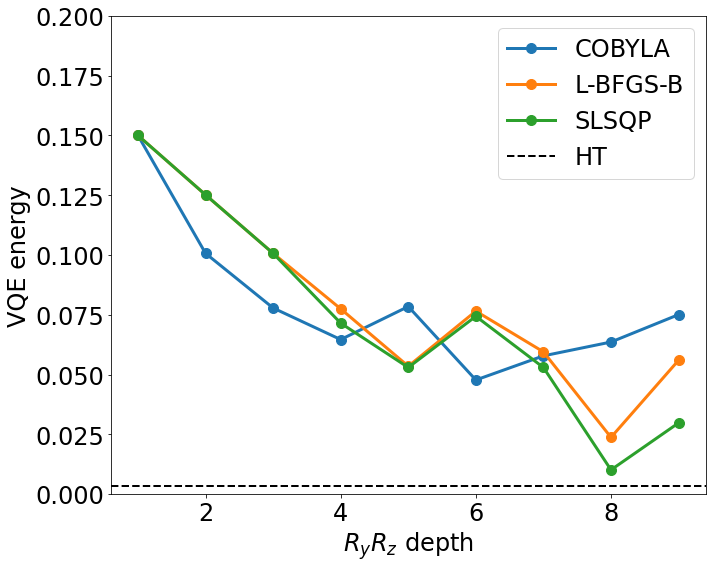

In [238]:
ht = 0.00328726
fig, ax = plt.subplots()
dfds.plot(marker="o", ylim=[0,0.2], ax=ax)
ax.axhline(ht,c="k",ls="--",lw="2",label="HT")
ax.set_ylabel("VQE energy")
ax.set_xlabel(r"$R_yR_z$"+" depth")
ax.legend(loc="upper right")
plt.savefig("../figures/miniBMN_L2_l02_ry-rz_nr100_max10000_depths.pdf")
plt.savefig("../figures/miniBMN_L2_l02_ry-rz_nr100_max10000_depths.png")
plt.savefig("../figures/miniBMN_L2_l02_ry-rz_nr100_max10000_depths.svg")

# Convergence plot. Bosonic BMN

## Get data

In [277]:
depth = 3
g2N = 2.0
varform = ['ry']
nrep = 100
maxit = 10000
dataprefix = "../data/bosBMN_L2"

In [278]:
params = dict()
params["l"] = str(g2N).replace(".", "")
params["d"] = depth
params["v"] = "-".join(varform)
params["m"] = maxit
params["n"] = nrep
params["f"] = dataprefix
params["s"] = 1.0

In [279]:
opt_label = ["COBYLA","L-BFGS-B","SLSQP","NELDER-MEAD"]
result = collect_data(opt_label,params,False)

Minimum energy

In [280]:
result.groupby('Optimizer').apply(min)

,counts,energy,casimir
Optimizer,,,
COBYLA,1,4.336383,NaN
L-BFGS-B,1,4.411034,NaN
SLSQP,1,4.336362,NaN
NELDER-MEAD,1,4.354113,NaN


Get stats

In [281]:
gs = dict()
for r in opt_label:
    gs[r] = result.loc[r].groupby('rep').apply(min).energy
gsdf = pd.DataFrame.from_dict(gs, dtype=float)

In [282]:
gsdf.describe().T[["min","max","mean","std"]].style.format(precision=5) # change the precision of the output

,min,max,mean,std
COBYLA,4.33638,5.20549,4.45130,0.12833
L-BFGS-B,4.41103,5.50000,4.55510,0.23231
SLSQP,4.33636,5.50000,4.55869,0.23437
NELDER-MEAD,4.35411,5.45168,4.48063,0.15477


## Plot convergence

In [96]:
ht = 3.13406

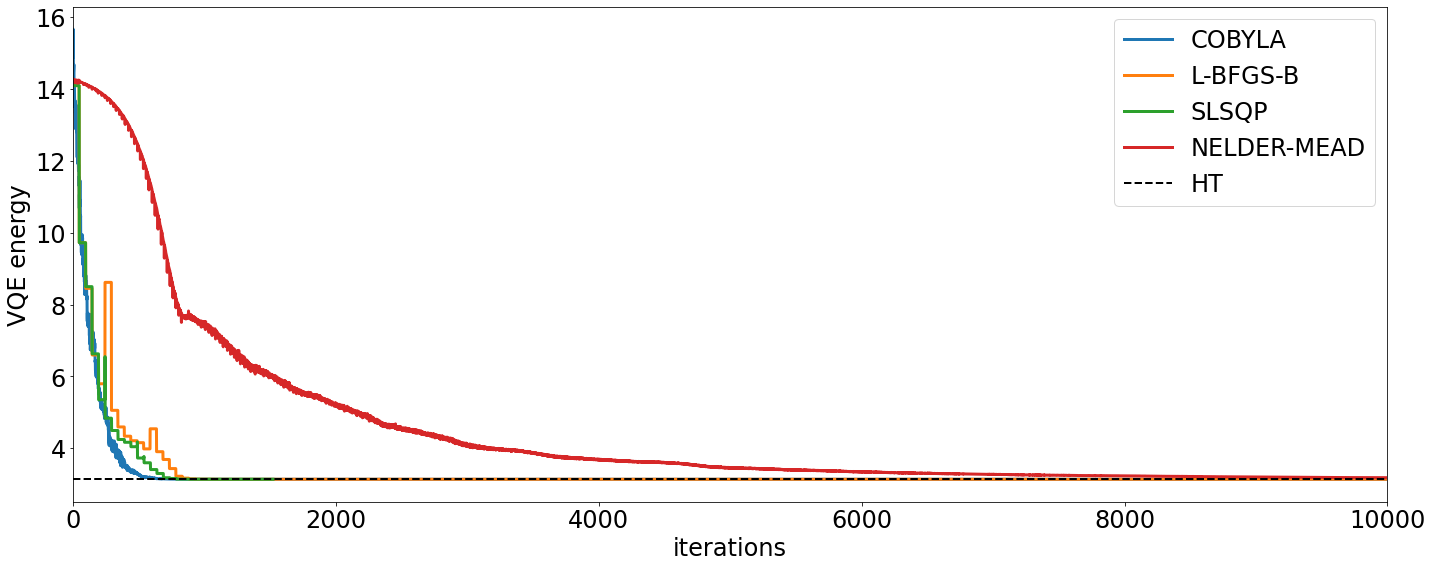

In [98]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")
ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
# filename = f"../figures/miniBMN_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}"
# plt.savefig(f"{filename}.pdf")
# plt.savefig(f"{filename}.png")

Zoom in

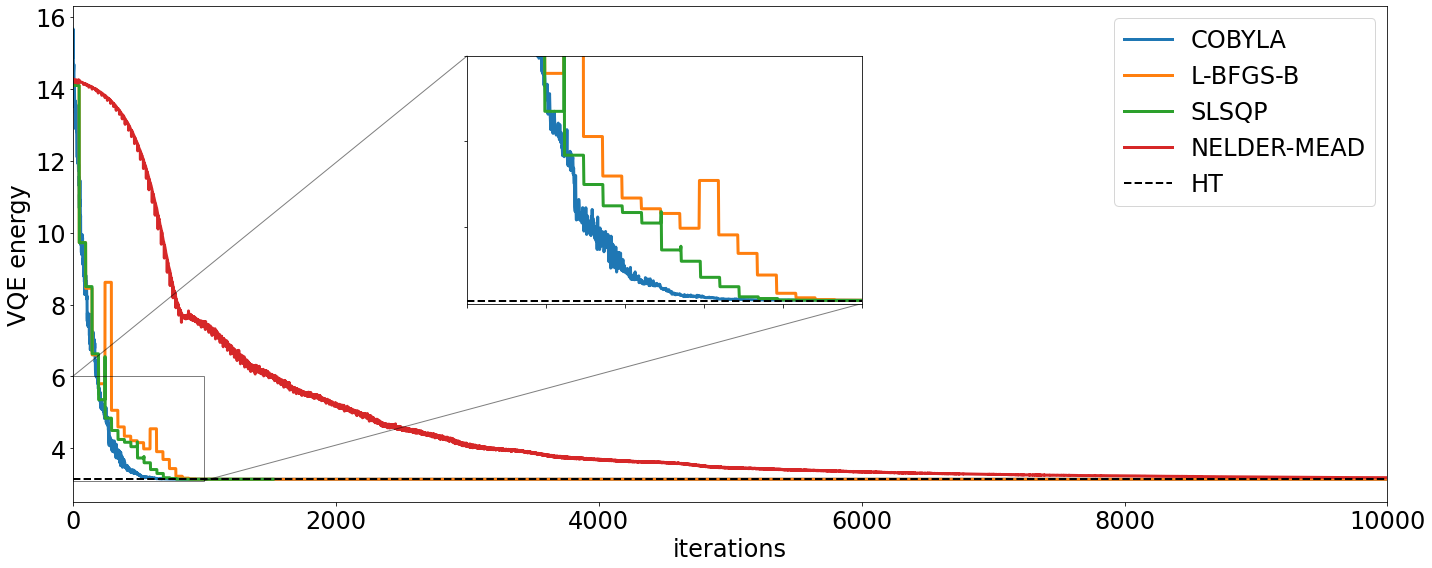

In [101]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")

# inset axes.... bounds are [x0, y0, width, height] for where to put it
axins = ax.inset_axes([0.3, 0.4, 0.3, 0.5])

for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,1000], legend=False, ax=axins)
axins.axhline(ht,c="k",ls="--", lw="2")
# sub region of the original image
x1, x2, y1, y2 = 0, 1000, 3.1, 6
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_ylabel('')
axins.set_xlabel('')

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
figprefix = dataprefix.replace("data","figures")
filename = f"{figprefix}_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}_zoom"
plt.savefig(f"{filename}.pdf")
plt.savefig(f"{filename}.png")
plt.savefig(f"{filename}.svg")

# Many couplings plots

## Get data from CSV

In [117]:
# df = pd.read_csv("../data/bosBMN_L2_couplings_ry_depth3_reps100.csv", index_col='l', dtype=float)
df = pd.read_csv("../data/bosBMN_L4_couplings_ry_depth3_reps100.csv", index_col='l', dtype=float)
df

,HT,COBYLA,L-BFGS-B,SLSQP,NELDER-MEAD
l,,,,,
0.5,3.29894,3.30975,3.30869,3.30974,3.31255
1.0,3.52625,3.54839,3.54748,3.54776,3.55292
2.0,3.89548,3.93452,3.93348,3.93946,3.95003


In [118]:
df = df.assign(COBYLA_HT=df['COBYLA']-df['HT'])
df = df.assign(L_BFGS_B_HT=df['L-BFGS-B']-df['HT'])
df = df.assign(SLSQP_HT=df['SLSQP']-df['HT'])
df = df.assign(NELDER_MEAD_HT=df['NELDER-MEAD']-df['HT'])

Text(0.5, 0, '$\\lambda$')

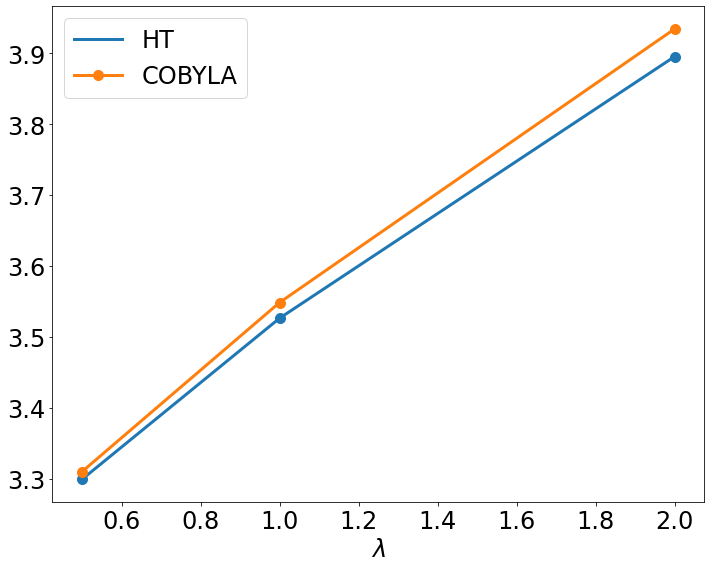

In [119]:
fig, ax = plt.subplots()
df.plot(y='HT', marker='o', ax=ax)
df.plot(y='COBYLA', marker='o', ax=ax)
ax.set_xlabel(r"$\lambda$")

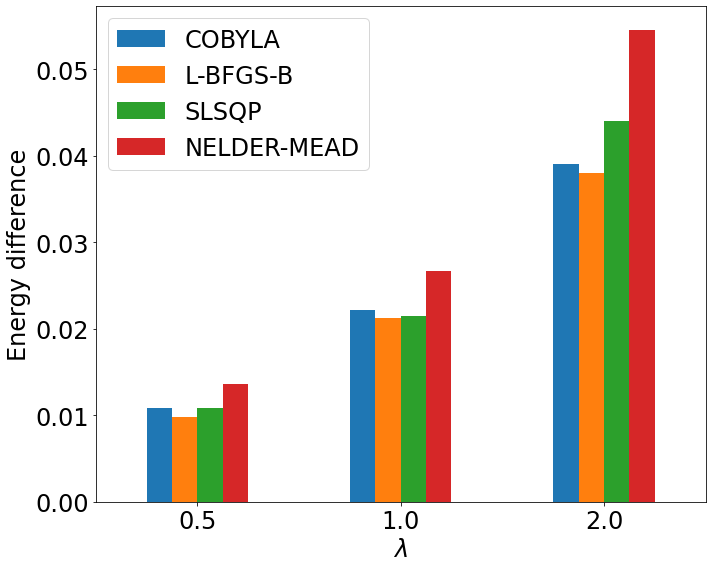

In [120]:
fig, ax = plt.subplots()
df.plot.bar(y=['COBYLA_HT','L_BFGS_B_HT','SLSQP_HT','NELDER_MEAD_HT'],label=False,ax=ax)
ax.tick_params(axis="x", rotation=0)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("Energy difference")
ax.legend(["COBYLA","L-BFGS-B","SLSQP","NELDER-MEAD"])
plt.savefig("../figures/bosBMN_L4_couplings_e-diff_ry_depth3_reps100_max10000.pdf")
plt.savefig("../figures/bosBMN_L4_couplings_e-diff_ry_depth3_reps100_max10000.png")
plt.savefig("../figures/bosBMN_L4_couplings_e-diff_ry_depth3_reps100_max10000.svg")

# Running times on Hokusai

## Bosonic model

This is using 4 threads

In [23]:
df = pd.read_csv("../data/times_mini.csv", dtype=float)
df.head()

,seconds
0,15364.494599
1,405.305940
2,3811.649292
3,4783.794722
4,6819.610956


In [ ]:
df.plot.hist()

In [24]:
df['minutes'] = df['seconds']/60.
df['hours'] = df['seconds']/3600.

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
seconds,146.0,5095.417006,6571.137347,45.074062,813.862891,3296.784038,5907.832123,35928.351402
minutes,146.0,84.923617,109.518956,0.751234,13.564382,54.946401,98.463869,598.805857
hours,146.0,1.415394,1.825316,0.012521,0.226073,0.915773,1.641064,9.980098


<AxesSubplot:ylabel='Frequency'>

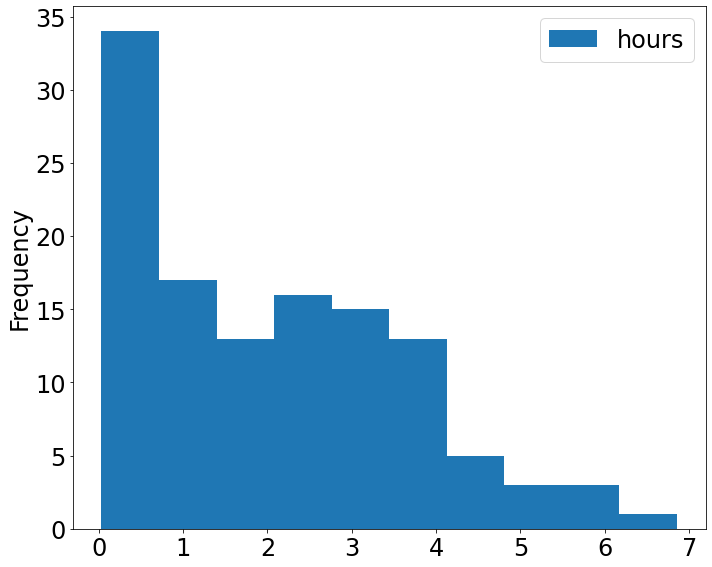

In [25]:
df.plot.hist(y='hours')